In [7]:
#!pip install tensorflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 615.3/615.3 MB 137.1 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 139.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 63.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 234.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 78.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 157.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 98.4 MB/s eta 0:00:00
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.1
    Uninstalling tensorboard-2.15.1:
      Successfully uninstalled tensorboard-2.15.1


In [2]:
import pandas as pd
import numpy as np 
from plotly import graph_objects as go
import matplotlib.pyplot as plt
from pathlib import Path

import sklearn
from sklearn.model_selection import train_test_split
import tensorflow as tf 

import json
from random import randint
from numpy import array
from numpy import argmax
from numpy import array_equal
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import Input, Dense, Embedding, GlobalAveragePooling1D
from tensorflow.keras.layers import SimpleRNN, GRU, LSTM, Dropout, BatchNormalization
from tensorflow.keras.regularizers import L1, L2, L1L2

2025-01-23 09:45:37.308423: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-23 09:45:37.544409: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1737625537.598460    1344 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1737625537.612993    1344 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-01-23 09:45:37.759009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

# Import et analyse du jeu de données

In [9]:
#!pip install kagglehub

In [10]:
"""
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ghostbat101/lung-x-ray-image-clinical-text-dataset")

print("Path to dataset files:", path)
"""

100%|██████████| 1.33G/1.33G [00:09<00:00, 158MB/s] 

Extracting files...


Path to dataset files: /teamspace/studios/this_studio/.cache/kagglehub/datasets/ghostbat101/lung-x-ray-image-clinical-text-dataset/versions/1


In [15]:
df_text = pd.read_csv("../../../Main_dataset/clinical_data.csv")
print(df_text.shape)
df_text.head()

(80000, 2)


,clinical_text,label
0,"Feel so, I have so much townish pain in, it di...",Lower Density
1,'Felt a sudden sharp pain in my that worse whe...,Lower Density
2,"'I have a, and my is mouth. I am full. I have ...",Higher Density
3,"No more breathing, tarsectomy I ' ve been feel...",Normal
4,I have a lung infection and peristome PAP. ' a...,Degenerative Infectious Diseases


In [13]:
df_text.iloc[1,0]

"'Felt a sudden sharp pain in my that worse when I tried to breathe radiumization in. I also short of breath and my skin was blue. very decentralization fatigued and my and were fast. I had a, hacking cough well.'"

In [28]:
img = tf.io.read_file("../../../Main_dataset/Chest_Changes/image_0020.jpg")
img = tf.image.decode_jpeg(img)
print(img.shape)
img = tf.reshape(img, [256,256])
import plotly.express as px
px.imshow(img, title="Chest_Changes_0020")

(256, 256, 1)


In [11]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
img_generator = ImageDataGenerator(
    horizontal_flip=False,
    vertical_flip=False,
    rescale=1/255, # Rescaling values from [0,255]->[0,1]
    validation_split=0.2
)

In [13]:
BATCH_SIZE = 64

img_generator_flow_train = img_generator.flow_from_directory(
    directory = "../../../Main_dataset/", # the folder where the class subfolders can be found
    target_size = (256,256), # The (height,width) of the produced images
    color_mode="grayscale",
    #class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=BATCH_SIZE, # The batch size of the produced batches
    shuffle = False, #Whether to shuffle after all files have been selected once
    subset = "training",
    seed=42
)

# img_generator_flow = img_generator.flow_from_directory(
#     directory = "../../../Main_dataset/", # the folder where the class subfolders can be found
#     target_size = (256,256), # The (height,width) of the produced images
#     color_mode="grayscale",
#     #class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
#     batch_size=BATCH_SIZE, # The batch size of the produced batches
#     shuffle = False, #Whether to shuffle after all files have been selected once
#     subset = "test",
#     seed=42
# )

img_generator_flow_val = img_generator.flow_from_directory(
    directory = "../../../Main_dataset/", # the folder where the class subfolders can be found
    target_size = (256,256), # The (height,width) of the produced images
    color_mode="grayscale",
    #class_mode = "sparse", # Wether the target should be represented by an index or a dummy vector
    batch_size=BATCH_SIZE, # The batch size of the produced batches
    shuffle = False, #Whether to shuffle after all files have been selected once
    subset = "validation",
    seed=42
)

Found 64000 images belonging to 8 classes.
Found 16000 images belonging to 8 classes.


In [14]:
imgs, labels = next(iter(img_generator_flow_train))
print(imgs.shape)
print(imgs)
print(labels)

(64, 256, 256, 1)
[[[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]]


 [[[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  ...

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.]
   [0.]]

  [[0.]
   [0.]
   [0.]
   ...
   [0.]
   [0.

2025-01-23 09:52:38.738508: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


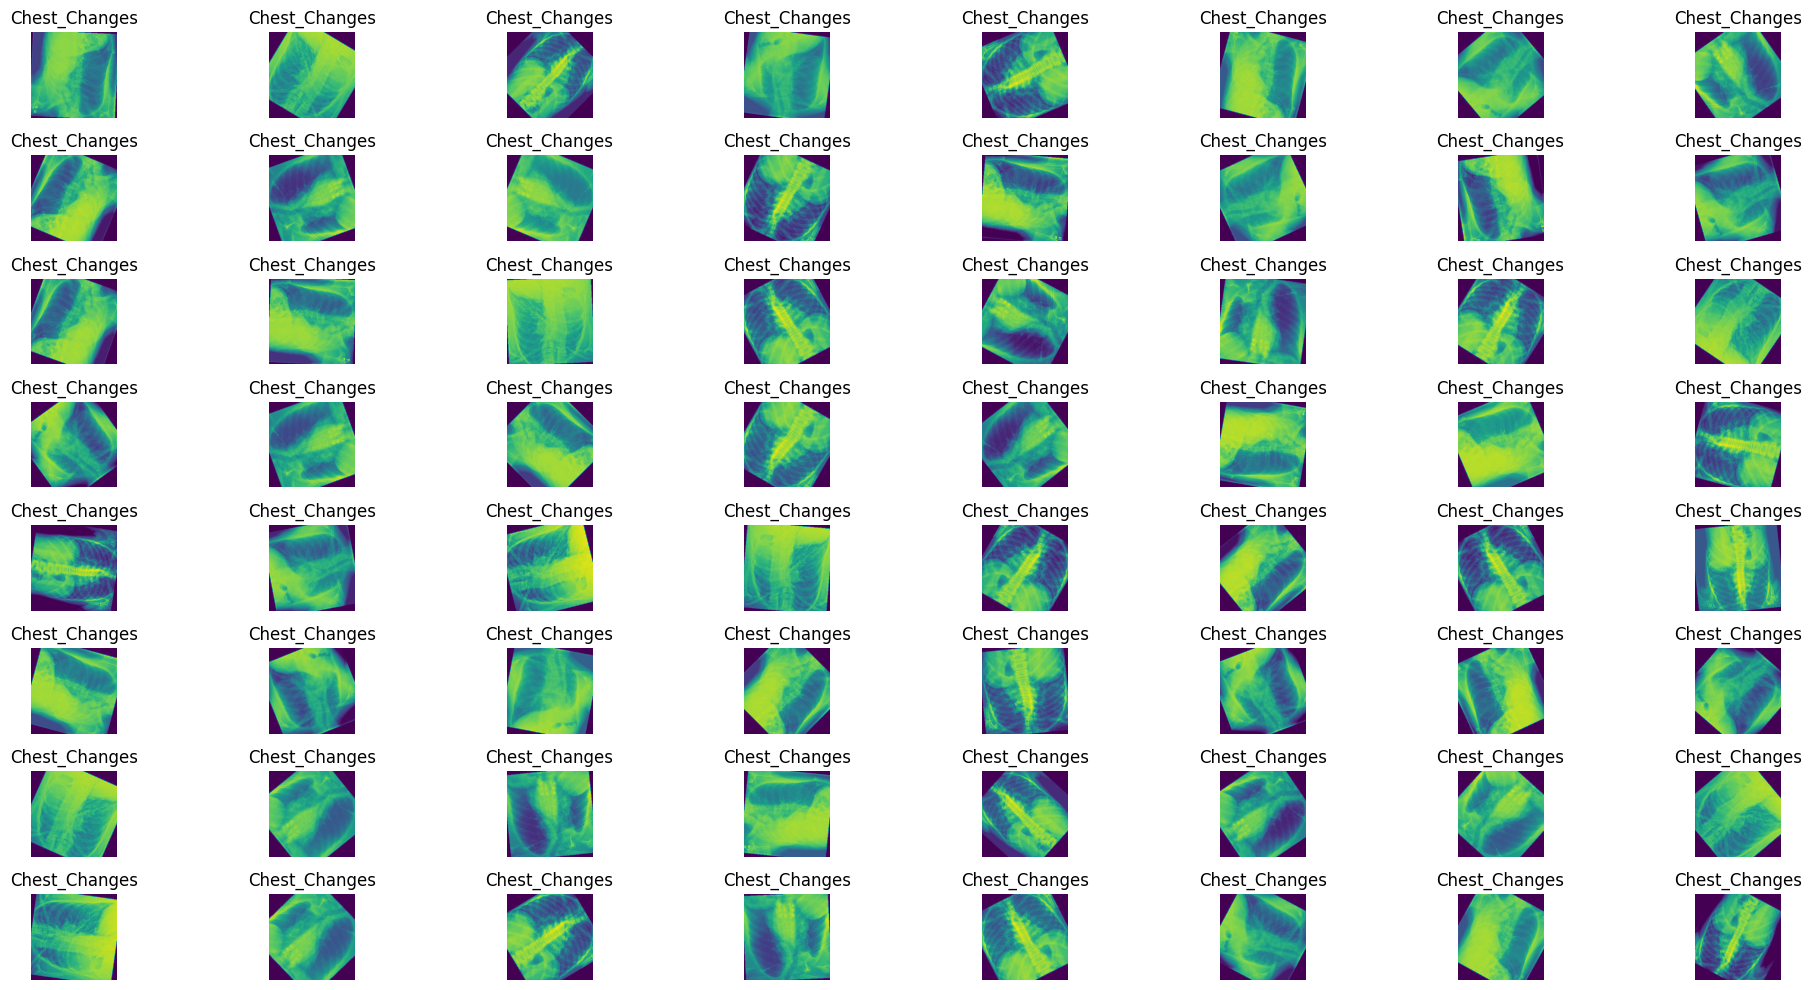

In [15]:
imgs, labels = next(iter(img_generator_flow))
fig, axes = plt.subplots(8, 8, figsize=(20, 10))
axes = axes.flatten()

for img, label, ax in zip(imgs, labels, axes):
    true_file_path = np.argmax(img_generator_flow.labels == tf.argmax(label))
    true_label_name = Path(img_generator_flow.filepaths[true_file_path]).parent.name
    ax.imshow(img)
    ax.set_title(true_label_name)
    ax.axis('off')

plt.tight_layout()
plt.show()

# Importer le modèle ViT (marche pas)

In [47]:
#!pip install transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 108.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.7/781.7 kB 30.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 116.1 MB/s eta 0:00:00


In [20]:

# code sur la page du modèle :
# Load model directly
from transformers import AutoImageProcessor, AutoModelForImageClassification

processor = AutoImageProcessor.from_pretrained("lxyuan/vit-xray-pneumonia-classification")
model_vit = AutoModelForImageClassification.from_pretrained("lxyuan/vit-xray-pneumonia-classification")

model_vit.compile(optimizer=tf.keras.optimizers.Adam(), #learning_rate = 0.001
              loss = tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

TypeError: compile() got an unexpected keyword argument 'optimizer'

In [19]:
"""
input_ids = tf.keras.Input(shape=(256, 256, ), dtype='float32')
attention_mask = tf.keras.Input(shape=(256, 256, ), dtype='float32')

encoded = transformer({"input_ids": input_ids, "attention_mask": attention_mask})
logits = encoded[0]
 
model = tf.keras.models.Model(inputs = {"input_ids": input_ids, "attention_mask": attention_mask}, outputs = logits)

model.summary()
"""

AttributeError: 'dict' object has no attribute 'dtype'

In [ ]:
model.compile()

Autre méthode pour loader le modèle

In [44]:
#!pip install tensorflow_hub

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 93.2 MB/s eta 0:00:00


In [45]:
import tensorflow_hub as hub
vit_tf_model = hub.KerasLayer("lxyuan/vit-xray-pneumonia-classification")
vit_tf_model.summary()

OSError: lxyuan/vit-xray-pneumonia-classification does not exist.